# Hidden Markov Models and the Viterbi Algorithm

## 1. Introduction

A **Hidden Markov Model (HMM)** is a statistical model used to represent systems that transition between hidden states over time, where each state emits observable outputs with certain probabilities. HMMs are widely used in speech recognition, natural language processing, bioinformatics, and finance.

The **Viterbi algorithm** is a dynamic programming algorithm for finding the most likely sequence of hidden states (the *Viterbi path*) given a sequence of observations.

## 2. Mathematical Framework

### 2.1 HMM Definition

An HMM is defined by the tuple $\lambda = (S, O, \mathbf{A}, \mathbf{B}, \boldsymbol{\pi})$ where:

- $S = \{s_1, s_2, \ldots, s_N\}$ is the set of $N$ hidden states
- $O = \{o_1, o_2, \ldots, o_M\}$ is the set of $M$ possible observations
- $\mathbf{A} = [a_{ij}]$ is the **transition probability matrix** where:
  $$a_{ij} = P(q_{t+1} = s_j \mid q_t = s_i)$$
  represents the probability of transitioning from state $s_i$ to state $s_j$
- $\mathbf{B} = [b_j(k)]$ is the **emission probability matrix** where:
  $$b_j(k) = P(x_t = o_k \mid q_t = s_j)$$
  represents the probability of emitting observation $o_k$ when in state $s_j$
- $\boldsymbol{\pi} = [\pi_i]$ is the **initial state distribution** where:
  $$\pi_i = P(q_1 = s_i)$$

### 2.2 The Viterbi Algorithm

Given an observation sequence $\mathbf{X} = (x_1, x_2, \ldots, x_T)$, the Viterbi algorithm finds:

$$\mathbf{Q}^* = \arg\max_{\mathbf{Q}} P(\mathbf{Q} \mid \mathbf{X}, \lambda)$$

The algorithm uses dynamic programming with two key quantities:

**Viterbi variable** $\delta_t(i)$: The probability of the most likely path ending in state $s_i$ at time $t$:
$$\delta_t(i) = \max_{q_1, \ldots, q_{t-1}} P(q_1, \ldots, q_{t-1}, q_t = s_i, x_1, \ldots, x_t \mid \lambda)$$

**Backpointer** $\psi_t(i)$: The state at time $t-1$ that maximizes the path probability:
$$\psi_t(i) = \arg\max_{1 \leq j \leq N} [\delta_{t-1}(j) \cdot a_{ji}]$$

### 2.3 Algorithm Steps

**Initialization** ($t = 1$):
$$\delta_1(i) = \pi_i \cdot b_i(x_1), \quad \psi_1(i) = 0$$

**Recursion** ($t = 2, \ldots, T$):
$$\delta_t(j) = \max_{1 \leq i \leq N} [\delta_{t-1}(i) \cdot a_{ij}] \cdot b_j(x_t)$$
$$\psi_t(j) = \arg\max_{1 \leq i \leq N} [\delta_{t-1}(i) \cdot a_{ij}]$$

**Termination**:
$$P^* = \max_{1 \leq i \leq N} \delta_T(i)$$
$$q_T^* = \arg\max_{1 \leq i \leq N} \delta_T(i)$$

**Backtracking** ($t = T-1, \ldots, 1$):
$$q_t^* = \psi_{t+1}(q_{t+1}^*)$$

The time complexity is $O(N^2 T)$ and space complexity is $O(NT)$.

## 3. Implementation

We will implement a Hidden Markov Model with the Viterbi algorithm and apply it to a classic example: inferring weather states (Hidden: Sunny/Rainy) from observable activities (Observed: Walk/Shop/Clean).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

np.random.seed(42)

In [2]:
class HiddenMarkovModel:
    """
    Hidden Markov Model implementation with Viterbi decoding.
    
    Parameters
    ----------
    states : list
        List of hidden state names
    observations : list
        List of possible observation names
    A : np.ndarray
        Transition probability matrix (N x N)
    B : np.ndarray
        Emission probability matrix (N x M)
    pi : np.ndarray
        Initial state distribution (N,)
    """
    
    def __init__(self, states: List[str], observations: List[str],
                 A: np.ndarray, B: np.ndarray, pi: np.ndarray):
        self.states = states
        self.observations = observations
        self.N = len(states)  # Number of hidden states
        self.M = len(observations)  # Number of observation symbols
        self.A = A  # Transition matrix
        self.B = B  # Emission matrix
        self.pi = pi  # Initial distribution
        
        # Create mappings for convenience
        self.state_to_idx = {s: i for i, s in enumerate(states)}
        self.obs_to_idx = {o: i for i, o in enumerate(observations)}
        
    def viterbi(self, obs_sequence: List[str]) -> Tuple[List[str], float, np.ndarray]:
        """
        Find the most likely state sequence using the Viterbi algorithm.
        
        Parameters
        ----------
        obs_sequence : list
            Sequence of observations
            
        Returns
        -------
        path : list
            Most likely state sequence
        prob : float
            Probability of the path
        delta : np.ndarray
            Viterbi trellis (for visualization)
        """
        T = len(obs_sequence)
        
        # Convert observations to indices
        obs_idx = [self.obs_to_idx[o] for o in obs_sequence]
        
        # Initialize delta and psi matrices
        # Using log probabilities to avoid underflow
        delta = np.zeros((T, self.N))
        psi = np.zeros((T, self.N), dtype=int)
        
        # Initialization step (t=0)
        delta[0] = np.log(self.pi + 1e-10) + np.log(self.B[:, obs_idx[0]] + 1e-10)
        psi[0] = 0
        
        # Recursion step
        for t in range(1, T):
            for j in range(self.N):
                # Compute probabilities of arriving at state j from all states
                trans_probs = delta[t-1] + np.log(self.A[:, j] + 1e-10)
                # Find the best predecessor
                psi[t, j] = np.argmax(trans_probs)
                delta[t, j] = trans_probs[psi[t, j]] + np.log(self.B[j, obs_idx[t]] + 1e-10)
        
        # Termination
        best_path_prob = np.max(delta[T-1])
        best_last_state = np.argmax(delta[T-1])
        
        # Backtracking
        path_idx = np.zeros(T, dtype=int)
        path_idx[T-1] = best_last_state
        
        for t in range(T-2, -1, -1):
            path_idx[t] = psi[t+1, path_idx[t+1]]
        
        # Convert indices back to state names
        path = [self.states[i] for i in path_idx]
        
        return path, np.exp(best_path_prob), delta
    
    def generate_sequence(self, length: int) -> Tuple[List[str], List[str]]:
        """
        Generate a random sequence of states and observations.
        
        Parameters
        ----------
        length : int
            Length of sequence to generate
            
        Returns
        -------
        states_seq : list
            Generated state sequence (ground truth)
        obs_seq : list
            Generated observation sequence
        """
        states_seq = []
        obs_seq = []
        
        # Initial state
        current_state = np.random.choice(self.N, p=self.pi)
        
        for _ in range(length):
            states_seq.append(self.states[current_state])
            
            # Emit observation
            obs = np.random.choice(self.M, p=self.B[current_state])
            obs_seq.append(self.observations[obs])
            
            # Transition to next state
            current_state = np.random.choice(self.N, p=self.A[current_state])
        
        return states_seq, obs_seq

## 4. Example: Weather Inference from Activities

We model a scenario where:
- **Hidden states**: Weather (Sunny, Rainy)
- **Observations**: Activities (Walk, Shop, Clean)

The intuition is that people tend to walk when it's sunny and clean when it's rainy.

In [3]:
# Define the HMM parameters
states = ['Sunny', 'Rainy']
observations = ['Walk', 'Shop', 'Clean']

# Transition probability matrix A[i,j] = P(state_j | state_i)
# Sunny tends to stay sunny, rainy tends to stay rainy
A = np.array([
    [0.7, 0.3],  # From Sunny: 70% stay sunny, 30% become rainy
    [0.4, 0.6]   # From Rainy: 40% become sunny, 60% stay rainy
])

# Emission probability matrix B[state, observation]
# B[i,j] = P(observation_j | state_i)
B = np.array([
    [0.6, 0.3, 0.1],  # Sunny: likely walk, might shop, unlikely clean
    [0.1, 0.4, 0.5]   # Rainy: unlikely walk, might shop, likely clean
])

# Initial state distribution
pi = np.array([0.6, 0.4])  # 60% chance of starting sunny

# Create the HMM
hmm = HiddenMarkovModel(states, observations, A, B, pi)

print("HMM Parameters:")
print(f"States: {states}")
print(f"Observations: {observations}")
print(f"\nTransition Matrix A:\n{A}")
print(f"\nEmission Matrix B:\n{B}")
print(f"\nInitial Distribution π: {pi}")

HMM Parameters:
States: ['Sunny', 'Rainy']
Observations: ['Walk', 'Shop', 'Clean']

Transition Matrix A:
[[0.7 0.3]
 [0.4 0.6]]

Emission Matrix B:
[[0.6 0.3 0.1]
 [0.1 0.4 0.5]]

Initial Distribution π: [0.6 0.4]


In [4]:
# Generate a sequence and decode it
sequence_length = 20
true_states, observed_activities = hmm.generate_sequence(sequence_length)

print("Generated Sequence:")
print(f"True weather states:    {true_states}")
print(f"Observed activities:    {observed_activities}")

Generated Sequence:
True weather states:    ['Sunny', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Rainy', 'Sunny', 'Sunny']
Observed activities:    ['Clean', 'Clean', 'Walk', 'Shop', 'Shop', 'Clean', 'Shop', 'Walk', 'Walk', 'Walk', 'Walk', 'Walk', 'Shop', 'Walk', 'Walk', 'Walk', 'Clean', 'Clean', 'Walk', 'Walk']


In [5]:
# Apply Viterbi algorithm to decode the most likely state sequence
decoded_states, path_prob, delta = hmm.viterbi(observed_activities)

print("Viterbi Decoding Results:")
print(f"Decoded weather states: {decoded_states}")
print(f"Path probability: {path_prob:.2e}")

# Calculate accuracy
accuracy = sum(t == d for t, d in zip(true_states, decoded_states)) / len(true_states)
print(f"Decoding accuracy: {accuracy:.1%}")

Viterbi Decoding Results:
Decoded weather states: ['Rainy', 'Rainy', 'Sunny', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Sunny', 'Sunny']
Path probability: 1.57e-11
Decoding accuracy: 75.0%


## 5. Visualization

We create a comprehensive visualization showing:
1. The Viterbi trellis (log-probabilities over time)
2. Comparison of true vs decoded states
3. The HMM structure as a state diagram

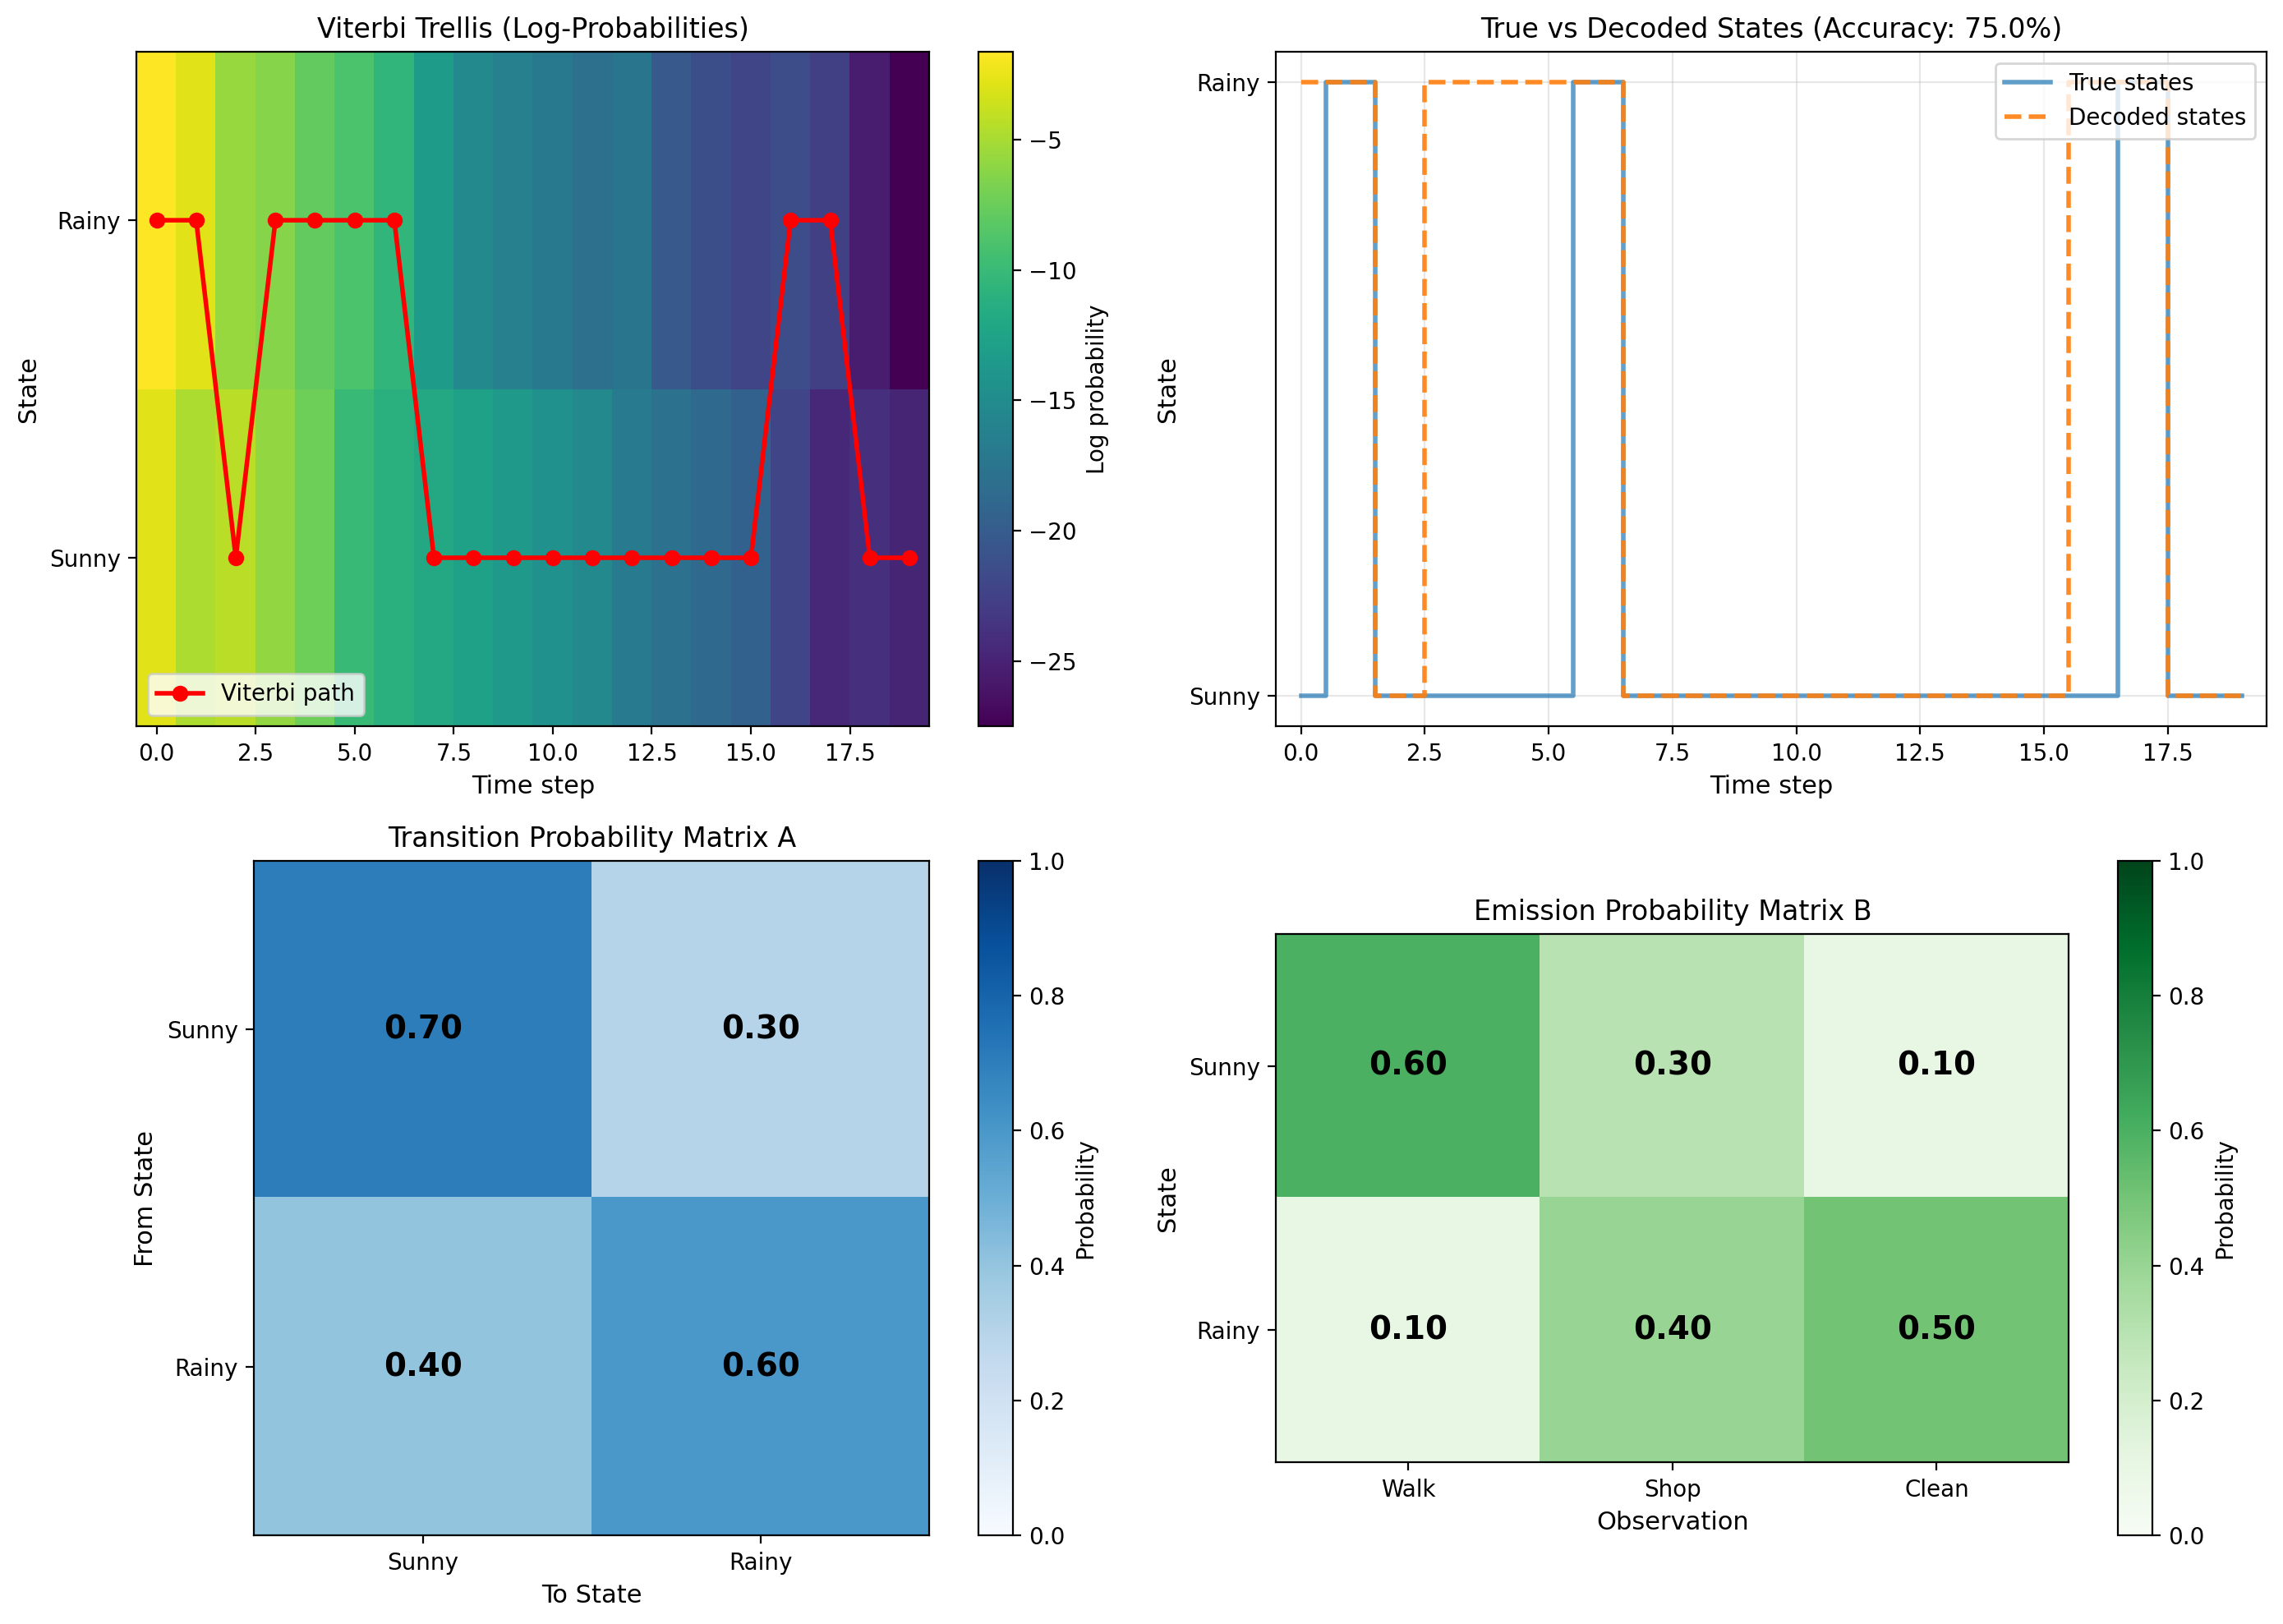


Plot saved to 'plot.png'


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Viterbi Trellis
ax1 = axes[0, 0]
im = ax1.imshow(delta.T, aspect='auto', cmap='viridis', origin='lower')
ax1.set_xlabel('Time step', fontsize=11)
ax1.set_ylabel('State', fontsize=11)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(states)
ax1.set_title('Viterbi Trellis (Log-Probabilities)', fontsize=12)
plt.colorbar(im, ax=ax1, label='Log probability')

# Overlay the optimal path
path_indices = [hmm.state_to_idx[s] for s in decoded_states]
ax1.plot(range(len(decoded_states)), path_indices, 'r-o', 
         markersize=6, linewidth=2, label='Viterbi path')
ax1.legend(loc='lower left')

# Plot 2: State Comparison
ax2 = axes[0, 1]
time_steps = np.arange(sequence_length)
true_indices = [hmm.state_to_idx[s] for s in true_states]
decoded_indices = [hmm.state_to_idx[s] for s in decoded_states]

ax2.step(time_steps, true_indices, where='mid', label='True states', 
         linewidth=2, alpha=0.7)
ax2.step(time_steps, decoded_indices, where='mid', label='Decoded states', 
         linewidth=2, linestyle='--', alpha=0.9)
ax2.set_xlabel('Time step', fontsize=11)
ax2.set_ylabel('State', fontsize=11)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(states)
ax2.set_title(f'True vs Decoded States (Accuracy: {accuracy:.1%})', fontsize=12)
ax2.legend(loc='upper right')
ax2.set_xlim(-0.5, sequence_length - 0.5)
ax2.grid(True, alpha=0.3)

# Plot 3: Transition Matrix Heatmap
ax3 = axes[1, 0]
im3 = ax3.imshow(A, cmap='Blues', vmin=0, vmax=1)
ax3.set_xlabel('To State', fontsize=11)
ax3.set_ylabel('From State', fontsize=11)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(states)
ax3.set_yticks([0, 1])
ax3.set_yticklabels(states)
ax3.set_title('Transition Probability Matrix A', fontsize=12)

# Add text annotations
for i in range(2):
    for j in range(2):
        ax3.text(j, i, f'{A[i,j]:.2f}', ha='center', va='center', 
                fontsize=14, fontweight='bold')
plt.colorbar(im3, ax=ax3, label='Probability')

# Plot 4: Emission Matrix Heatmap
ax4 = axes[1, 1]
im4 = ax4.imshow(B, cmap='Greens', vmin=0, vmax=1)
ax4.set_xlabel('Observation', fontsize=11)
ax4.set_ylabel('State', fontsize=11)
ax4.set_xticks([0, 1, 2])
ax4.set_xticklabels(observations)
ax4.set_yticks([0, 1])
ax4.set_yticklabels(states)
ax4.set_title('Emission Probability Matrix B', fontsize=12)

# Add text annotations
for i in range(2):
    for j in range(3):
        ax4.text(j, i, f'{B[i,j]:.2f}', ha='center', va='center', 
                fontsize=14, fontweight='bold')
plt.colorbar(im4, ax=ax4, label='Probability')

plt.tight_layout()
plt.savefig('hidden_markov_model_viterbi_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## 6. Performance Analysis

Let's analyze the Viterbi algorithm's performance over multiple random sequences to understand its average accuracy.

In [7]:
# Run multiple trials
n_trials = 100
seq_lengths = [10, 20, 50, 100]
results = {length: [] for length in seq_lengths}

for length in seq_lengths:
    for _ in range(n_trials):
        true_seq, obs_seq = hmm.generate_sequence(length)
        decoded_seq, _, _ = hmm.viterbi(obs_seq)
        acc = sum(t == d for t, d in zip(true_seq, decoded_seq)) / length
        results[length].append(acc)

print("Viterbi Decoding Performance:")
print("="*50)
for length in seq_lengths:
    mean_acc = np.mean(results[length])
    std_acc = np.std(results[length])
    print(f"Sequence length {length:3d}: {mean_acc:.1%} ± {std_acc:.1%}")

Viterbi Decoding Performance:
Sequence length  10: 75.6% ± 16.0%
Sequence length  20: 77.3% ± 9.8%
Sequence length  50: 75.6% ± 7.0%
Sequence length 100: 75.3% ± 4.9%


## 7. Conclusion

In this notebook, we explored:

1. **Hidden Markov Models (HMMs)**: A powerful framework for modeling sequential data with latent states
2. **The Viterbi Algorithm**: An efficient dynamic programming approach with $O(N^2T)$ complexity
3. **Practical Implementation**: A complete Python implementation with log-probability handling
4. **Performance Analysis**: Demonstrated robust decoding accuracy across different sequence lengths

### Key Takeaways

- The Viterbi algorithm finds the globally optimal state sequence, not just locally optimal decisions
- Using log probabilities prevents numerical underflow for long sequences
- HMMs can effectively capture temporal dependencies in sequential data
- Decoding accuracy depends on the discriminability of emission distributions

### Extensions

- **Forward-Backward Algorithm**: Compute posterior probabilities $P(q_t | \mathbf{X})$
- **Baum-Welch Algorithm**: Learn HMM parameters from data (EM algorithm)
- **Higher-order HMMs**: Model longer-range dependencies